# Face Generation

### Get the Data

We'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train our adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) So we should prepare to define deeper networks and train them for a longer time to get good results. GPU is required for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />


In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* We can decide on any reasonable `batch_size` parameter
* Our `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = (32,32)


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, We can view some images! We should seen square images of somewhat-centered faces.

We'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

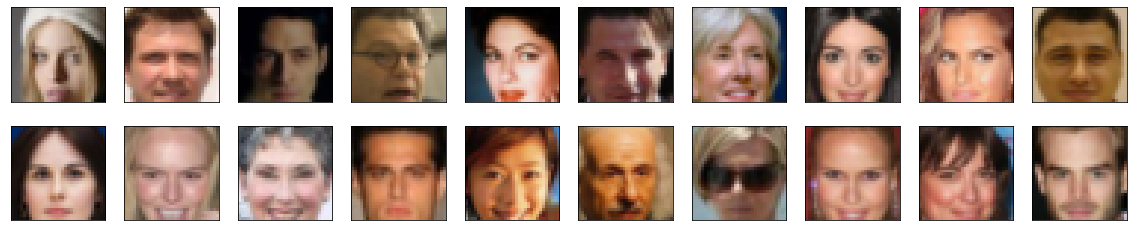

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:

def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    min, max = sorted(feature_range)
    # scale to feature_range and return scaled x
    
    x = x * (max - min) + min
    
    return x


In [8]:

# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.8588)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv( in_chnls, out_chnls, kernel_size, stride = 2, padding = 1, batch_norm = True ):
    """
    Helper method to quickly create convolutional layer with batch normalization
    :param in_chnls : input channels
    :param out_chnls : output channels
    :param kernel_size : kernel size
    :param stride : stride for the convolution
    :param padding : padding for the convolution
    :param batch_norm : batch normalization flag
    """
    layers = []
    conv_layer = nn.Conv2d(in_chnls, out_chnls, kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_chnls))
    
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.fc = nn.Linear(4 * 4 * conv_dim * 4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        
        x = x.view(-1, 4 * 4 * self.conv_dim * 4)
        x = self.fc(x)
        
        return x


Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv( in_chnls, out_chnls, kernel_size, stride = 2, padding = 1, batch_norm = True ):
    """
    Helper method to quickly create Transposed convolutional layer with batch normalization
    :param in_chnls : input channels
    :param out_chnls : output channels
    :param kernel_size : kernel size
    :param stride : stride for the convolution
    :param padding : padding for the convolution
    :param batch_norm : batch normalization flag
    """
    layers = []
    trans_conv_layer = nn.ConvTranspose2d(in_chnls, out_chnls, kernel_size, stride, padding, bias=False)
    
    layers.append(trans_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_chnls))
    
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, 4 * 4 * conv_dim * 4)
        self.deconv1 = deconv(conv_dim * 4, conv_dim * 2 , 4)
        self.deconv2 = deconv(conv_dim * 2, conv_dim , 4)
        self.deconv3 = deconv(conv_dim , 3 , 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 4 ,4 , 4)
        
        x = F.leaky_relu(self.deconv1(x) , 0.2)
        x = F.leaky_relu(self.deconv2(x) , 0.2)
        x = torch.tanh(self.deconv3(x))
        
        return x



Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [19]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if "Conv2d" in classname or "Linear" in classname:
        nn.init.normal_(m.weight.data, mean = 0.0 , std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
#     elif "BatchNorm2d" in classname:
#         nn.init.constant_(m.weight.data, 1)
#         nn.init.constant_(m.bias.data, 0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        D.to(device)
        G.to(device)
        print('Models moved to GPU.')
    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [30]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Models moved to GPU.
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2),

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [22]:

import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [37]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    labels = torch.ones(D_out.size(0))
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze() , labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    labels = torch.zeros(D_out.size(0))
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze() , labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [38]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters() , lr, [beta1,beta2])
g_optimizer = optim.Adam(G.parameters() , lr, [beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [39]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            d_out = D(real_images)
            d_real_loss = real_loss(d_out)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            g_out = G(z)
            d_fake_out = D(g_out)
            
            d_fake_loss = fake_loss(d_fake_out)
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            g_out = G(z)
            d_fake_out = D(g_out)
            
            g_loss = real_loss(d_fake_out)
            
            g_loss.backward()
            g_optimizer.step()
            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [40]:
# set number of epochs 
n_epochs = 100


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.4199 | g_loss: 0.9323
Epoch [    1/  100] | d_loss: 0.2107 | g_loss: 3.5456
Epoch [    1/  100] | d_loss: 0.0524 | g_loss: 4.3651
Epoch [    1/  100] | d_loss: 0.5575 | g_loss: 2.2519
Epoch [    1/  100] | d_loss: 0.1376 | g_loss: 3.7310
Epoch [    1/  100] | d_loss: 0.4175 | g_loss: 2.9187
Epoch [    1/  100] | d_loss: 0.3534 | g_loss: 2.6716
Epoch [    1/  100] | d_loss: 0.4165 | g_loss: 2.0065
Epoch [    1/  100] | d_loss: 0.7003 | g_loss: 2.6485
Epoch [    1/  100] | d_loss: 0.4204 | g_loss: 2.2510
Epoch [    1/  100] | d_loss: 0.3809 | g_loss: 2.4053
Epoch [    1/  100] | d_loss: 0.3441 | g_loss: 2.6665
Epoch [    1/  100] | d_loss: 0.4131 | g_loss: 2.4305
Epoch [    1/  100] | d_loss: 0.6072 | g_loss: 2.9735
Epoch [    1/  100] | d_loss: 0.7601 | g_loss: 2.3200
Epoch [    1/  100] | d_loss: 0.4626 | g_loss: 2.9678
Epoch [    1/  100] | d_loss: 0.5282 | g_loss: 1.5291
Epoch [    1/  100] | d_loss: 1.0729 | g_loss: 2.6658
Epoch [    1/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.6075 | g_loss: 1.5393
Epoch [    3/  100] | d_loss: 1.0891 | g_loss: 0.7653
Epoch [    3/  100] | d_loss: 0.4655 | g_loss: 1.3711
Epoch [    3/  100] | d_loss: 0.3493 | g_loss: 2.0867
Epoch [    3/  100] | d_loss: 0.3729 | g_loss: 2.5535
Epoch [    3/  100] | d_loss: 0.4794 | g_loss: 2.1622
Epoch [    3/  100] | d_loss: 0.7046 | g_loss: 1.9502
Epoch [    3/  100] | d_loss: 0.4826 | g_loss: 1.8022
Epoch [    3/  100] | d_loss: 0.6918 | g_loss: 2.5339
Epoch [    3/  100] | d_loss: 0.1844 | g_loss: 2.9575
Epoch [    3/  100] | d_loss: 0.3681 | g_loss: 2.8904
Epoch [    3/  100] | d_loss: 0.4839 | g_loss: 2.4049
Epoch [    3/  100] | d_loss: 0.8694 | g_loss: 2.6748
Epoch [    3/  100] | d_loss: 0.4862 | g_loss: 2.0564
Epoch [    3/  100] | d_loss: 0.6580 | g_loss: 2.4303
Epoch [    3/  100] | d_loss: 1.3210 | g_loss: 4.3552
Epoch [    3/  100] | d_loss: 0.7329 | g_loss: 1.8194
Epoch [    3/  100] | d_loss: 0.4893 | g_loss: 2.1203
Epoch [    3/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.2315 | g_loss: 2.6904
Epoch [    6/  100] | d_loss: 0.3829 | g_loss: 1.5760
Epoch [    6/  100] | d_loss: 0.2667 | g_loss: 2.8414
Epoch [    6/  100] | d_loss: 1.4503 | g_loss: 6.1087
Epoch [    6/  100] | d_loss: 0.2425 | g_loss: 2.7350
Epoch [    6/  100] | d_loss: 0.3354 | g_loss: 2.1607
Epoch [    6/  100] | d_loss: 0.2588 | g_loss: 3.0766
Epoch [    6/  100] | d_loss: 0.6225 | g_loss: 1.4453
Epoch [    6/  100] | d_loss: 1.0581 | g_loss: 4.6839
Epoch [    6/  100] | d_loss: 0.2459 | g_loss: 2.0498
Epoch [    6/  100] | d_loss: 0.5243 | g_loss: 3.2151
Epoch [    6/  100] | d_loss: 0.3334 | g_loss: 1.6487
Epoch [    6/  100] | d_loss: 1.2493 | g_loss: 0.8517
Epoch [    6/  100] | d_loss: 0.6796 | g_loss: 2.7635
Epoch [    6/  100] | d_loss: 0.4029 | g_loss: 3.2068
Epoch [    6/  100] | d_loss: 0.1895 | g_loss: 4.6074
Epoch [    6/  100] | d_loss: 0.5833 | g_loss: 3.1430
Epoch [    6/  100] | d_loss: 0.3094 | g_loss: 1.8350
Epoch [    6/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.1591 | g_loss: 3.3179
Epoch [    9/  100] | d_loss: 0.6493 | g_loss: 3.0966
Epoch [    9/  100] | d_loss: 0.3827 | g_loss: 3.3130
Epoch [    9/  100] | d_loss: 0.1567 | g_loss: 3.3153
Epoch [    9/  100] | d_loss: 0.2442 | g_loss: 4.0809
Epoch [    9/  100] | d_loss: 0.1304 | g_loss: 3.1248
Epoch [    9/  100] | d_loss: 0.3310 | g_loss: 2.0431
Epoch [    9/  100] | d_loss: 0.1521 | g_loss: 3.7893
Epoch [    9/  100] | d_loss: 0.5870 | g_loss: 1.7225
Epoch [    9/  100] | d_loss: 0.1764 | g_loss: 3.5912
Epoch [    9/  100] | d_loss: 1.7117 | g_loss: 6.5798
Epoch [    9/  100] | d_loss: 0.2902 | g_loss: 2.6068
Epoch [    9/  100] | d_loss: 0.3165 | g_loss: 2.6256
Epoch [    9/  100] | d_loss: 0.2143 | g_loss: 2.6735
Epoch [    9/  100] | d_loss: 1.0254 | g_loss: 5.1437
Epoch [    9/  100] | d_loss: 0.3306 | g_loss: 3.8612
Epoch [    9/  100] | d_loss: 0.5221 | g_loss: 2.0410
Epoch [    9/  100] | d_loss: 0.1803 | g_loss: 1.9829
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.2651 | g_loss: 4.5042
Epoch [   11/  100] | d_loss: 0.1242 | g_loss: 3.5177
Epoch [   11/  100] | d_loss: 0.0848 | g_loss: 3.5241
Epoch [   11/  100] | d_loss: 0.1493 | g_loss: 3.1370
Epoch [   11/  100] | d_loss: 0.1944 | g_loss: 3.6556
Epoch [   11/  100] | d_loss: 0.1210 | g_loss: 4.0508
Epoch [   11/  100] | d_loss: 0.0523 | g_loss: 3.6953
Epoch [   11/  100] | d_loss: 0.0750 | g_loss: 3.4602
Epoch [   11/  100] | d_loss: 0.2101 | g_loss: 3.3549
Epoch [   11/  100] | d_loss: 0.2950 | g_loss: 2.3060
Epoch [   11/  100] | d_loss: 0.1767 | g_loss: 4.5016
Epoch [   11/  100] | d_loss: 0.0570 | g_loss: 3.4185
Epoch [   11/  100] | d_loss: 0.1390 | g_loss: 3.9336
Epoch [   11/  100] | d_loss: 0.1159 | g_loss: 5.8504
Epoch [   11/  100] | d_loss: 0.4503 | g_loss: 2.8031
Epoch [   11/  100] | d_loss: 0.3911 | g_loss: 1.5362
Epoch [   11/  100] | d_loss: 0.2839 | g_loss: 2.9850
Epoch [   11/  100] | d_loss: 0.2341 | g_loss: 2.8997
Epoch [   11/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.0379 | g_loss: 4.2281
Epoch [   14/  100] | d_loss: 0.3852 | g_loss: 5.1268
Epoch [   14/  100] | d_loss: 0.0830 | g_loss: 4.3920
Epoch [   14/  100] | d_loss: 0.0825 | g_loss: 4.6886
Epoch [   14/  100] | d_loss: 0.2575 | g_loss: 5.4780
Epoch [   14/  100] | d_loss: 0.1051 | g_loss: 3.6523
Epoch [   14/  100] | d_loss: 0.1147 | g_loss: 4.9909
Epoch [   14/  100] | d_loss: 0.4306 | g_loss: 6.8343
Epoch [   14/  100] | d_loss: 0.0699 | g_loss: 2.8043
Epoch [   14/  100] | d_loss: 0.0747 | g_loss: 4.6869
Epoch [   14/  100] | d_loss: 0.4284 | g_loss: 2.0950
Epoch [   14/  100] | d_loss: 0.3382 | g_loss: 3.6946
Epoch [   14/  100] | d_loss: 0.2910 | g_loss: 3.3366
Epoch [   14/  100] | d_loss: 0.0814 | g_loss: 2.6878
Epoch [   14/  100] | d_loss: 0.1777 | g_loss: 3.8259
Epoch [   14/  100] | d_loss: 0.1304 | g_loss: 3.0139
Epoch [   14/  100] | d_loss: 0.1830 | g_loss: 4.5418
Epoch [   14/  100] | d_loss: 0.2946 | g_loss: 5.0843
Epoch [   14/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.0746 | g_loss: 5.3045
Epoch [   17/  100] | d_loss: 0.1020 | g_loss: 3.9215
Epoch [   17/  100] | d_loss: 0.1321 | g_loss: 4.5704
Epoch [   17/  100] | d_loss: 0.1355 | g_loss: 3.7055
Epoch [   17/  100] | d_loss: 0.3110 | g_loss: 2.3242
Epoch [   17/  100] | d_loss: 0.1152 | g_loss: 4.0554
Epoch [   17/  100] | d_loss: 0.0617 | g_loss: 4.5829
Epoch [   17/  100] | d_loss: 0.0371 | g_loss: 5.7125
Epoch [   17/  100] | d_loss: 0.0675 | g_loss: 5.2573
Epoch [   17/  100] | d_loss: 0.0581 | g_loss: 5.7268
Epoch [   17/  100] | d_loss: 0.0835 | g_loss: 3.8490
Epoch [   17/  100] | d_loss: 0.0662 | g_loss: 4.4862
Epoch [   17/  100] | d_loss: 0.2667 | g_loss: 4.8108
Epoch [   17/  100] | d_loss: 0.1222 | g_loss: 2.4059
Epoch [   17/  100] | d_loss: 0.1211 | g_loss: 5.8186
Epoch [   17/  100] | d_loss: 0.0810 | g_loss: 3.8037
Epoch [   17/  100] | d_loss: 0.3443 | g_loss: 3.7013
Epoch [   17/  100] | d_loss: 0.3257 | g_loss: 4.7105
Epoch [   17/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.1066 | g_loss: 3.3673
Epoch [   19/  100] | d_loss: 0.1324 | g_loss: 5.2361
Epoch [   19/  100] | d_loss: 0.0936 | g_loss: 5.6912
Epoch [   19/  100] | d_loss: 0.1333 | g_loss: 4.8179
Epoch [   19/  100] | d_loss: 0.0965 | g_loss: 5.2672
Epoch [   19/  100] | d_loss: 0.0668 | g_loss: 5.0612
Epoch [   19/  100] | d_loss: 0.0677 | g_loss: 3.8507
Epoch [   19/  100] | d_loss: 0.1075 | g_loss: 3.9214
Epoch [   19/  100] | d_loss: 0.1055 | g_loss: 5.6707
Epoch [   19/  100] | d_loss: 0.0647 | g_loss: 5.6921
Epoch [   19/  100] | d_loss: 0.0317 | g_loss: 4.6953
Epoch [   19/  100] | d_loss: 0.0910 | g_loss: 4.6585
Epoch [   19/  100] | d_loss: 0.5389 | g_loss: 4.9212
Epoch [   19/  100] | d_loss: 0.1415 | g_loss: 4.4105
Epoch [   19/  100] | d_loss: 0.1929 | g_loss: 3.3443
Epoch [   19/  100] | d_loss: 0.3351 | g_loss: 3.6633
Epoch [   19/  100] | d_loss: 0.5755 | g_loss: 2.7546
Epoch [   19/  100] | d_loss: 0.0597 | g_loss: 5.5095
Epoch [   19/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.0463 | g_loss: 5.8783
Epoch [   22/  100] | d_loss: 0.0501 | g_loss: 4.9753
Epoch [   22/  100] | d_loss: 0.0691 | g_loss: 5.0629
Epoch [   22/  100] | d_loss: 0.1101 | g_loss: 3.7250
Epoch [   22/  100] | d_loss: 0.2135 | g_loss: 4.9475
Epoch [   22/  100] | d_loss: 0.0196 | g_loss: 4.9953
Epoch [   22/  100] | d_loss: 1.0069 | g_loss: 7.7702
Epoch [   22/  100] | d_loss: 0.4449 | g_loss: 3.0446
Epoch [   22/  100] | d_loss: 0.0773 | g_loss: 3.8470
Epoch [   22/  100] | d_loss: 0.2115 | g_loss: 4.8809
Epoch [   22/  100] | d_loss: 0.2766 | g_loss: 4.2585
Epoch [   22/  100] | d_loss: 0.4792 | g_loss: 2.9014
Epoch [   22/  100] | d_loss: 0.0657 | g_loss: 5.0036
Epoch [   22/  100] | d_loss: 0.0753 | g_loss: 4.9868
Epoch [   22/  100] | d_loss: 0.0592 | g_loss: 4.3874
Epoch [   22/  100] | d_loss: 0.0871 | g_loss: 5.4125
Epoch [   22/  100] | d_loss: 0.1018 | g_loss: 4.3455
Epoch [   22/  100] | d_loss: 0.0797 | g_loss: 4.3865
Epoch [   22/  100] | d_loss

Epoch [   25/  100] | d_loss: 0.0631 | g_loss: 4.5380
Epoch [   25/  100] | d_loss: 0.0397 | g_loss: 4.5901
Epoch [   25/  100] | d_loss: 0.0187 | g_loss: 6.0060
Epoch [   25/  100] | d_loss: 0.0192 | g_loss: 4.9496
Epoch [   25/  100] | d_loss: 0.0680 | g_loss: 4.9872
Epoch [   25/  100] | d_loss: 0.9724 | g_loss: 0.7158
Epoch [   25/  100] | d_loss: 0.0804 | g_loss: 3.8653
Epoch [   25/  100] | d_loss: 0.0247 | g_loss: 4.5359
Epoch [   25/  100] | d_loss: 0.0409 | g_loss: 4.6830
Epoch [   25/  100] | d_loss: 0.1117 | g_loss: 5.2215
Epoch [   25/  100] | d_loss: 0.1042 | g_loss: 5.9570
Epoch [   25/  100] | d_loss: 1.6723 | g_loss: 8.4805
Epoch [   25/  100] | d_loss: 0.2371 | g_loss: 4.3434
Epoch [   25/  100] | d_loss: 0.1262 | g_loss: 5.0178
Epoch [   25/  100] | d_loss: 0.1194 | g_loss: 2.8751
Epoch [   25/  100] | d_loss: 0.0352 | g_loss: 6.0570
Epoch [   25/  100] | d_loss: 0.0785 | g_loss: 4.9378
Epoch [   25/  100] | d_loss: 0.0380 | g_loss: 6.0784
Epoch [   25/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.0597 | g_loss: 4.7761
Epoch [   27/  100] | d_loss: 0.1163 | g_loss: 5.0774
Epoch [   27/  100] | d_loss: 0.0222 | g_loss: 6.1973
Epoch [   27/  100] | d_loss: 0.0429 | g_loss: 6.0139
Epoch [   27/  100] | d_loss: 0.0202 | g_loss: 6.2320
Epoch [   27/  100] | d_loss: 0.1984 | g_loss: 3.3875
Epoch [   27/  100] | d_loss: 0.0842 | g_loss: 5.8360
Epoch [   27/  100] | d_loss: 0.1309 | g_loss: 5.8561
Epoch [   27/  100] | d_loss: 0.9555 | g_loss: 3.2161
Epoch [   27/  100] | d_loss: 0.1509 | g_loss: 6.9834
Epoch [   27/  100] | d_loss: 0.0240 | g_loss: 3.9123
Epoch [   27/  100] | d_loss: 0.1273 | g_loss: 5.3970
Epoch [   27/  100] | d_loss: 0.0868 | g_loss: 4.9520
Epoch [   27/  100] | d_loss: 0.0759 | g_loss: 5.7705
Epoch [   27/  100] | d_loss: 0.0328 | g_loss: 5.7707
Epoch [   27/  100] | d_loss: 0.0855 | g_loss: 4.9598
Epoch [   27/  100] | d_loss: 0.0306 | g_loss: 5.3066
Epoch [   27/  100] | d_loss: 0.1715 | g_loss: 4.3879
Epoch [   27/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.0516 | g_loss: 5.4313
Epoch [   30/  100] | d_loss: 0.0321 | g_loss: 4.3356
Epoch [   30/  100] | d_loss: 0.8280 | g_loss: 9.8127
Epoch [   30/  100] | d_loss: 0.1349 | g_loss: 5.8354
Epoch [   30/  100] | d_loss: 0.0620 | g_loss: 4.3995
Epoch [   30/  100] | d_loss: 0.0279 | g_loss: 6.1807
Epoch [   30/  100] | d_loss: 0.1557 | g_loss: 5.5229
Epoch [   30/  100] | d_loss: 0.0337 | g_loss: 5.8403
Epoch [   30/  100] | d_loss: 0.4388 | g_loss: 1.4404
Epoch [   30/  100] | d_loss: 0.1509 | g_loss: 3.7179
Epoch [   30/  100] | d_loss: 0.0268 | g_loss: 5.3425
Epoch [   30/  100] | d_loss: 0.0437 | g_loss: 4.5085
Epoch [   30/  100] | d_loss: 0.1692 | g_loss: 3.9066
Epoch [   30/  100] | d_loss: 0.1041 | g_loss: 6.4921
Epoch [   30/  100] | d_loss: 0.0505 | g_loss: 5.5024
Epoch [   30/  100] | d_loss: 0.2067 | g_loss: 6.0647
Epoch [   30/  100] | d_loss: 0.2074 | g_loss: 6.1571
Epoch [   30/  100] | d_loss: 0.1737 | g_loss: 4.1564
Epoch [   30/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.3394 | g_loss: 5.0262
Epoch [   33/  100] | d_loss: 0.0489 | g_loss: 6.4409
Epoch [   33/  100] | d_loss: 0.0744 | g_loss: 6.0529
Epoch [   33/  100] | d_loss: 0.0387 | g_loss: 5.2235
Epoch [   33/  100] | d_loss: 0.0265 | g_loss: 4.6568
Epoch [   33/  100] | d_loss: 0.0104 | g_loss: 4.9957
Epoch [   33/  100] | d_loss: 0.0462 | g_loss: 5.4054
Epoch [   33/  100] | d_loss: 0.0469 | g_loss: 4.0634
Epoch [   33/  100] | d_loss: 0.0882 | g_loss: 4.4045
Epoch [   33/  100] | d_loss: 0.0731 | g_loss: 6.4820
Epoch [   33/  100] | d_loss: 0.0339 | g_loss: 5.0935
Epoch [   33/  100] | d_loss: 0.1708 | g_loss: 3.7700
Epoch [   33/  100] | d_loss: 0.0140 | g_loss: 6.9134
Epoch [   33/  100] | d_loss: 0.0069 | g_loss: 6.8250
Epoch [   33/  100] | d_loss: 0.0167 | g_loss: 6.9008
Epoch [   33/  100] | d_loss: 0.0914 | g_loss: 5.3704
Epoch [   33/  100] | d_loss: 0.0499 | g_loss: 5.6348
Epoch [   33/  100] | d_loss: 0.1047 | g_loss: 6.1124
Epoch [   33/  100] | d_loss

Epoch [   35/  100] | d_loss: 0.0813 | g_loss: 3.6664
Epoch [   35/  100] | d_loss: 0.0743 | g_loss: 5.6680
Epoch [   35/  100] | d_loss: 0.0154 | g_loss: 5.0628
Epoch [   35/  100] | d_loss: 0.0274 | g_loss: 4.8900
Epoch [   35/  100] | d_loss: 0.1912 | g_loss: 6.6926
Epoch [   35/  100] | d_loss: 0.0870 | g_loss: 5.5867
Epoch [   35/  100] | d_loss: 0.1206 | g_loss: 4.6002
Epoch [   35/  100] | d_loss: 0.0135 | g_loss: 5.0987
Epoch [   35/  100] | d_loss: 0.0236 | g_loss: 5.4965
Epoch [   35/  100] | d_loss: 0.0315 | g_loss: 5.9615
Epoch [   35/  100] | d_loss: 0.0655 | g_loss: 4.5504
Epoch [   35/  100] | d_loss: 0.0330 | g_loss: 5.1969
Epoch [   35/  100] | d_loss: 0.0529 | g_loss: 6.2135
Epoch [   35/  100] | d_loss: 0.0905 | g_loss: 8.0709
Epoch [   35/  100] | d_loss: 0.0722 | g_loss: 5.0727
Epoch [   35/  100] | d_loss: 1.6446 | g_loss: 0.2136
Epoch [   35/  100] | d_loss: 0.2432 | g_loss: 7.6367
Epoch [   35/  100] | d_loss: 0.1269 | g_loss: 5.6918
Epoch [   35/  100] | d_loss

Epoch [   38/  100] | d_loss: 0.0579 | g_loss: 5.8660
Epoch [   38/  100] | d_loss: 0.5679 | g_loss: 5.8077
Epoch [   38/  100] | d_loss: 0.0269 | g_loss: 8.0358
Epoch [   38/  100] | d_loss: 0.0584 | g_loss: 4.9303
Epoch [   38/  100] | d_loss: 0.3671 | g_loss: 9.3208
Epoch [   38/  100] | d_loss: 0.1650 | g_loss: 3.8249
Epoch [   38/  100] | d_loss: 0.3078 | g_loss: 4.2070
Epoch [   38/  100] | d_loss: 0.1622 | g_loss: 5.2042
Epoch [   38/  100] | d_loss: 0.0456 | g_loss: 6.5485
Epoch [   38/  100] | d_loss: 0.0548 | g_loss: 5.6570
Epoch [   38/  100] | d_loss: 0.0134 | g_loss: 4.7893
Epoch [   38/  100] | d_loss: 0.0359 | g_loss: 7.2666
Epoch [   38/  100] | d_loss: 0.0135 | g_loss: 6.5185
Epoch [   38/  100] | d_loss: 0.2021 | g_loss: 4.3474
Epoch [   38/  100] | d_loss: 0.0704 | g_loss: 4.7740
Epoch [   38/  100] | d_loss: 0.0404 | g_loss: 5.8156
Epoch [   38/  100] | d_loss: 0.1194 | g_loss: 7.0005
Epoch [   38/  100] | d_loss: 0.2859 | g_loss: 4.3290
Epoch [   38/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.0216 | g_loss: 4.9949
Epoch [   41/  100] | d_loss: 0.0108 | g_loss: 6.5325
Epoch [   41/  100] | d_loss: 0.0094 | g_loss: 5.6457
Epoch [   41/  100] | d_loss: 0.0921 | g_loss: 5.5445
Epoch [   41/  100] | d_loss: 0.0174 | g_loss: 6.6428
Epoch [   41/  100] | d_loss: 0.0382 | g_loss: 4.3493
Epoch [   41/  100] | d_loss: 0.0134 | g_loss: 6.0739
Epoch [   41/  100] | d_loss: 0.0364 | g_loss: 3.8621
Epoch [   41/  100] | d_loss: 0.0115 | g_loss: 6.6344
Epoch [   41/  100] | d_loss: 0.1164 | g_loss: 4.6735
Epoch [   41/  100] | d_loss: 0.0189 | g_loss: 5.3050
Epoch [   41/  100] | d_loss: 0.0440 | g_loss: 4.6255
Epoch [   41/  100] | d_loss: 0.0111 | g_loss: 7.3160
Epoch [   41/  100] | d_loss: 0.0121 | g_loss: 7.4027
Epoch [   41/  100] | d_loss: 0.0935 | g_loss: 4.6040
Epoch [   41/  100] | d_loss: 0.0550 | g_loss: 6.3554
Epoch [   41/  100] | d_loss: 0.2807 | g_loss: 4.0434
Epoch [   41/  100] | d_loss: 0.0163 | g_loss: 6.5259
Epoch [   41/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.0387 | g_loss: 3.7248
Epoch [   43/  100] | d_loss: 0.0893 | g_loss: 5.8151
Epoch [   43/  100] | d_loss: 0.2393 | g_loss: 2.8268
Epoch [   43/  100] | d_loss: 0.0097 | g_loss: 6.5068
Epoch [   43/  100] | d_loss: 0.0401 | g_loss: 4.4844
Epoch [   43/  100] | d_loss: 0.0514 | g_loss: 4.8635
Epoch [   43/  100] | d_loss: 0.0112 | g_loss: 7.4686
Epoch [   43/  100] | d_loss: 0.0168 | g_loss: 7.7821
Epoch [   43/  100] | d_loss: 0.0337 | g_loss: 5.8534
Epoch [   43/  100] | d_loss: 0.3800 | g_loss: 6.2001
Epoch [   43/  100] | d_loss: 0.0407 | g_loss: 6.4465
Epoch [   43/  100] | d_loss: 0.2079 | g_loss: 5.9562
Epoch [   43/  100] | d_loss: 0.0273 | g_loss: 5.8297
Epoch [   43/  100] | d_loss: 0.3860 | g_loss: 5.3677
Epoch [   43/  100] | d_loss: 0.1163 | g_loss: 3.6750
Epoch [   43/  100] | d_loss: 0.0527 | g_loss: 6.5578
Epoch [   43/  100] | d_loss: 0.0214 | g_loss: 5.8737
Epoch [   43/  100] | d_loss: 0.0830 | g_loss: 5.9823
Epoch [   43/  100] | d_loss

Epoch [   46/  100] | d_loss: 0.0130 | g_loss: 13.2945
Epoch [   46/  100] | d_loss: 0.0713 | g_loss: 6.3268
Epoch [   46/  100] | d_loss: 0.0624 | g_loss: 7.6919
Epoch [   46/  100] | d_loss: 0.0065 | g_loss: 4.7642
Epoch [   46/  100] | d_loss: 0.0276 | g_loss: 7.0661
Epoch [   46/  100] | d_loss: 0.0139 | g_loss: 6.7007
Epoch [   46/  100] | d_loss: 0.0572 | g_loss: 7.2304
Epoch [   46/  100] | d_loss: 0.0129 | g_loss: 7.8851
Epoch [   46/  100] | d_loss: 0.0355 | g_loss: 5.7757
Epoch [   46/  100] | d_loss: 0.0889 | g_loss: 10.6575
Epoch [   46/  100] | d_loss: 0.0507 | g_loss: 8.8931
Epoch [   46/  100] | d_loss: 0.0002 | g_loss: 13.3912
Epoch [   46/  100] | d_loss: 0.3080 | g_loss: 5.3635
Epoch [   46/  100] | d_loss: 0.0064 | g_loss: 6.6161
Epoch [   46/  100] | d_loss: 0.0031 | g_loss: 8.2770
Epoch [   46/  100] | d_loss: 0.2737 | g_loss: 8.9811
Epoch [   46/  100] | d_loss: 0.0229 | g_loss: 6.3945
Epoch [   46/  100] | d_loss: 0.0087 | g_loss: 5.6276
Epoch [   46/  100] | d_l

Epoch [   49/  100] | d_loss: 0.2543 | g_loss: 7.7745
Epoch [   49/  100] | d_loss: 0.0733 | g_loss: 6.5061
Epoch [   49/  100] | d_loss: 0.0036 | g_loss: 8.7423
Epoch [   49/  100] | d_loss: 0.0071 | g_loss: 8.7270
Epoch [   49/  100] | d_loss: 0.0104 | g_loss: 7.9493
Epoch [   49/  100] | d_loss: 0.1351 | g_loss: 13.6832
Epoch [   49/  100] | d_loss: 0.1771 | g_loss: 9.3867
Epoch [   49/  100] | d_loss: 0.0621 | g_loss: 6.6832
Epoch [   49/  100] | d_loss: 0.0994 | g_loss: 8.4000
Epoch [   49/  100] | d_loss: 0.2507 | g_loss: 13.5576
Epoch [   49/  100] | d_loss: 0.0056 | g_loss: 9.9738
Epoch [   49/  100] | d_loss: 0.0100 | g_loss: 9.1008
Epoch [   49/  100] | d_loss: 0.0040 | g_loss: 11.5456
Epoch [   49/  100] | d_loss: 1.3294 | g_loss: 19.0662
Epoch [   49/  100] | d_loss: 0.1142 | g_loss: 12.7148
Epoch [   49/  100] | d_loss: 0.1185 | g_loss: 6.9433
Epoch [   49/  100] | d_loss: 0.0010 | g_loss: 9.1183
Epoch [   49/  100] | d_loss: 0.0232 | g_loss: 7.4078
Epoch [   49/  100] | d

Epoch [   51/  100] | d_loss: 0.0913 | g_loss: 7.5656
Epoch [   51/  100] | d_loss: 0.0011 | g_loss: 9.9313
Epoch [   51/  100] | d_loss: 0.0127 | g_loss: 7.7947
Epoch [   51/  100] | d_loss: 0.0088 | g_loss: 4.4138
Epoch [   51/  100] | d_loss: 0.0109 | g_loss: 8.7262
Epoch [   51/  100] | d_loss: 0.0265 | g_loss: 8.9536
Epoch [   51/  100] | d_loss: 0.0130 | g_loss: 7.3473
Epoch [   51/  100] | d_loss: 0.1549 | g_loss: 7.2217
Epoch [   51/  100] | d_loss: 0.0008 | g_loss: 8.0981
Epoch [   51/  100] | d_loss: 0.3096 | g_loss: 3.6849
Epoch [   51/  100] | d_loss: 0.0427 | g_loss: 8.2945
Epoch [   51/  100] | d_loss: 0.1558 | g_loss: 9.2729
Epoch [   51/  100] | d_loss: 0.0590 | g_loss: 5.8374
Epoch [   51/  100] | d_loss: 0.0204 | g_loss: 7.8223
Epoch [   51/  100] | d_loss: 0.0556 | g_loss: 7.2800
Epoch [   51/  100] | d_loss: 0.0034 | g_loss: 9.0242
Epoch [   51/  100] | d_loss: 0.1951 | g_loss: 10.0484
Epoch [   51/  100] | d_loss: 0.0555 | g_loss: 5.2481
Epoch [   51/  100] | d_los

Epoch [   54/  100] | d_loss: 0.0233 | g_loss: 5.4751
Epoch [   54/  100] | d_loss: 0.3511 | g_loss: 4.5149
Epoch [   54/  100] | d_loss: 0.0341 | g_loss: 6.3240
Epoch [   54/  100] | d_loss: 0.0060 | g_loss: 6.0820
Epoch [   54/  100] | d_loss: 0.0570 | g_loss: 8.8976
Epoch [   54/  100] | d_loss: 1.4147 | g_loss: 11.3288
Epoch [   54/  100] | d_loss: 0.0460 | g_loss: 4.7586
Epoch [   54/  100] | d_loss: 0.0386 | g_loss: 4.3258
Epoch [   54/  100] | d_loss: 0.0060 | g_loss: 9.6501
Epoch [   54/  100] | d_loss: 0.1774 | g_loss: 11.1545
Epoch [   54/  100] | d_loss: 0.1517 | g_loss: 3.6807
Epoch [   54/  100] | d_loss: 0.0664 | g_loss: 7.5651
Epoch [   54/  100] | d_loss: 0.2097 | g_loss: 7.6700
Epoch [   54/  100] | d_loss: 0.0449 | g_loss: 6.7845
Epoch [   54/  100] | d_loss: 0.0383 | g_loss: 7.9367
Epoch [   54/  100] | d_loss: 0.0017 | g_loss: 9.8234
Epoch [   54/  100] | d_loss: 0.0147 | g_loss: 7.0524
Epoch [   54/  100] | d_loss: 0.0120 | g_loss: 6.2195
Epoch [   54/  100] | d_lo

Epoch [   57/  100] | d_loss: 0.0159 | g_loss: 6.7169
Epoch [   57/  100] | d_loss: 0.1448 | g_loss: 7.8757
Epoch [   57/  100] | d_loss: 0.0024 | g_loss: 7.4447
Epoch [   57/  100] | d_loss: 0.0297 | g_loss: 8.0815
Epoch [   57/  100] | d_loss: 0.0104 | g_loss: 9.0465
Epoch [   57/  100] | d_loss: 0.0234 | g_loss: 7.1412
Epoch [   57/  100] | d_loss: 0.1363 | g_loss: 5.6231
Epoch [   57/  100] | d_loss: 0.0252 | g_loss: 8.5532
Epoch [   57/  100] | d_loss: 0.0056 | g_loss: 8.1650
Epoch [   57/  100] | d_loss: 0.0578 | g_loss: 6.5242
Epoch [   57/  100] | d_loss: 0.0050 | g_loss: 7.7236
Epoch [   57/  100] | d_loss: 0.0147 | g_loss: 8.0873
Epoch [   57/  100] | d_loss: 0.0835 | g_loss: 9.0720
Epoch [   57/  100] | d_loss: 0.0411 | g_loss: 9.4924
Epoch [   57/  100] | d_loss: 0.0096 | g_loss: 5.2799
Epoch [   57/  100] | d_loss: 0.0039 | g_loss: 8.6353
Epoch [   57/  100] | d_loss: 0.0117 | g_loss: 9.3930
Epoch [   57/  100] | d_loss: 0.1730 | g_loss: 5.7316
Epoch [   57/  100] | d_loss

Epoch [   59/  100] | d_loss: 0.0131 | g_loss: 12.2286
Epoch [   59/  100] | d_loss: 0.2523 | g_loss: 10.7920
Epoch [   59/  100] | d_loss: 0.0608 | g_loss: 5.8783
Epoch [   59/  100] | d_loss: 0.0094 | g_loss: 7.6591
Epoch [   59/  100] | d_loss: 0.0215 | g_loss: 8.6314
Epoch [   59/  100] | d_loss: 2.4784 | g_loss: 2.5647
Epoch [   59/  100] | d_loss: 0.0357 | g_loss: 9.2522
Epoch [   59/  100] | d_loss: 0.2245 | g_loss: 10.1818
Epoch [   59/  100] | d_loss: 0.1450 | g_loss: 8.1519
Epoch [   59/  100] | d_loss: 0.0546 | g_loss: 8.1578
Epoch [   59/  100] | d_loss: 0.0118 | g_loss: 9.3777
Epoch [   59/  100] | d_loss: 0.0057 | g_loss: 7.0049
Epoch [   59/  100] | d_loss: 0.1892 | g_loss: 6.0964
Epoch [   59/  100] | d_loss: 0.0446 | g_loss: 7.1972
Epoch [   59/  100] | d_loss: 0.2422 | g_loss: 8.1116
Epoch [   59/  100] | d_loss: 0.0228 | g_loss: 5.2453
Epoch [   59/  100] | d_loss: 0.0249 | g_loss: 7.5023
Epoch [   59/  100] | d_loss: 0.3456 | g_loss: 10.2575
Epoch [   59/  100] | d_

Epoch [   62/  100] | d_loss: 0.0025 | g_loss: 9.5552
Epoch [   62/  100] | d_loss: 0.0012 | g_loss: 7.4887
Epoch [   62/  100] | d_loss: 0.1757 | g_loss: 8.0076
Epoch [   62/  100] | d_loss: 0.0654 | g_loss: 0.9471
Epoch [   62/  100] | d_loss: 0.2067 | g_loss: 9.3593
Epoch [   62/  100] | d_loss: 0.2509 | g_loss: 6.4030
Epoch [   62/  100] | d_loss: 0.1255 | g_loss: 7.7301
Epoch [   62/  100] | d_loss: 0.2224 | g_loss: 10.4613
Epoch [   62/  100] | d_loss: 0.0723 | g_loss: 4.5288
Epoch [   62/  100] | d_loss: 0.0009 | g_loss: 9.0375
Epoch [   62/  100] | d_loss: 0.0165 | g_loss: 7.4131
Epoch [   62/  100] | d_loss: 0.0235 | g_loss: 8.7289
Epoch [   62/  100] | d_loss: 0.0507 | g_loss: 7.0477
Epoch [   62/  100] | d_loss: 1.8874 | g_loss: 0.9874
Epoch [   62/  100] | d_loss: 0.0151 | g_loss: 7.9028
Epoch [   62/  100] | d_loss: 0.5351 | g_loss: 13.1028
Epoch [   62/  100] | d_loss: 0.1765 | g_loss: 6.4951
Epoch [   62/  100] | d_loss: 0.0039 | g_loss: 6.9224
Epoch [   62/  100] | d_lo

Epoch [   65/  100] | d_loss: 0.0644 | g_loss: 9.4816
Epoch [   65/  100] | d_loss: 0.0047 | g_loss: 7.6117
Epoch [   65/  100] | d_loss: 0.0073 | g_loss: 6.6500
Epoch [   65/  100] | d_loss: 0.0734 | g_loss: 8.7434
Epoch [   65/  100] | d_loss: 0.2842 | g_loss: 4.3678
Epoch [   65/  100] | d_loss: 0.0237 | g_loss: 9.4932
Epoch [   65/  100] | d_loss: 0.0502 | g_loss: 5.1355
Epoch [   65/  100] | d_loss: 0.0596 | g_loss: 7.4303
Epoch [   65/  100] | d_loss: 0.0963 | g_loss: 8.4774
Epoch [   65/  100] | d_loss: 0.0080 | g_loss: 7.5265
Epoch [   65/  100] | d_loss: 0.0061 | g_loss: 7.1728
Epoch [   65/  100] | d_loss: 0.0289 | g_loss: 6.5990
Epoch [   65/  100] | d_loss: 0.0738 | g_loss: 8.8553
Epoch [   65/  100] | d_loss: 0.0871 | g_loss: 4.1873
Epoch [   65/  100] | d_loss: 0.0256 | g_loss: 7.7015
Epoch [   65/  100] | d_loss: 0.1130 | g_loss: 7.4507
Epoch [   65/  100] | d_loss: 0.0060 | g_loss: 6.5974
Epoch [   65/  100] | d_loss: 0.0593 | g_loss: 8.0649
Epoch [   65/  100] | d_loss

Epoch [   67/  100] | d_loss: 0.0060 | g_loss: 7.0042
Epoch [   67/  100] | d_loss: 0.0218 | g_loss: 5.1405
Epoch [   67/  100] | d_loss: 0.0351 | g_loss: 6.0786
Epoch [   67/  100] | d_loss: 0.0216 | g_loss: 10.1156
Epoch [   67/  100] | d_loss: 0.0069 | g_loss: 6.3219
Epoch [   67/  100] | d_loss: 0.0249 | g_loss: 4.8225
Epoch [   67/  100] | d_loss: 0.0064 | g_loss: 7.8891
Epoch [   67/  100] | d_loss: 0.0059 | g_loss: 5.8593
Epoch [   67/  100] | d_loss: 0.1077 | g_loss: 8.3201
Epoch [   67/  100] | d_loss: 0.0025 | g_loss: 8.8733
Epoch [   67/  100] | d_loss: 0.0056 | g_loss: 9.3736
Epoch [   67/  100] | d_loss: 0.0197 | g_loss: 7.8360
Epoch [   67/  100] | d_loss: 0.0341 | g_loss: 14.6627
Epoch [   67/  100] | d_loss: 0.0075 | g_loss: 9.5537
Epoch [   67/  100] | d_loss: 0.0022 | g_loss: 9.0583
Epoch [   67/  100] | d_loss: 0.0004 | g_loss: 11.4379
Epoch [   67/  100] | d_loss: 0.0208 | g_loss: 10.0291
Epoch [   67/  100] | d_loss: 0.0001 | g_loss: 14.3585
Epoch [   67/  100] | d

Epoch [   70/  100] | d_loss: 0.0138 | g_loss: 8.7798
Epoch [   70/  100] | d_loss: 0.1326 | g_loss: 4.2669
Epoch [   70/  100] | d_loss: 0.0132 | g_loss: 9.8110
Epoch [   70/  100] | d_loss: 0.2833 | g_loss: 5.4735
Epoch [   70/  100] | d_loss: 0.0138 | g_loss: 7.2652
Epoch [   70/  100] | d_loss: 0.0159 | g_loss: 4.0102
Epoch [   70/  100] | d_loss: 0.0061 | g_loss: 10.4143
Epoch [   70/  100] | d_loss: 0.0254 | g_loss: 6.9779
Epoch [   70/  100] | d_loss: 0.0207 | g_loss: 7.6649
Epoch [   70/  100] | d_loss: 0.0182 | g_loss: 8.0437
Epoch [   70/  100] | d_loss: 0.1035 | g_loss: 6.1416
Epoch [   70/  100] | d_loss: 0.0086 | g_loss: 12.0544
Epoch [   70/  100] | d_loss: 0.0550 | g_loss: 4.6115
Epoch [   70/  100] | d_loss: 0.0523 | g_loss: 9.9324
Epoch [   70/  100] | d_loss: 0.0472 | g_loss: 6.1584
Epoch [   70/  100] | d_loss: 1.0899 | g_loss: 6.0523
Epoch [   70/  100] | d_loss: 0.0932 | g_loss: 5.1899
Epoch [   70/  100] | d_loss: 0.7086 | g_loss: 12.4274
Epoch [   70/  100] | d_l

Epoch [   73/  100] | d_loss: 0.2791 | g_loss: 7.3609
Epoch [   73/  100] | d_loss: 0.0977 | g_loss: 5.0094
Epoch [   73/  100] | d_loss: 0.0077 | g_loss: 9.4681
Epoch [   73/  100] | d_loss: 0.1400 | g_loss: 6.2123
Epoch [   73/  100] | d_loss: 0.2567 | g_loss: 1.1687
Epoch [   73/  100] | d_loss: 0.0037 | g_loss: 5.1167
Epoch [   73/  100] | d_loss: 0.0056 | g_loss: 7.6740
Epoch [   73/  100] | d_loss: 0.0329 | g_loss: 7.3839
Epoch [   73/  100] | d_loss: 0.1483 | g_loss: 13.7904
Epoch [   73/  100] | d_loss: 0.0095 | g_loss: 11.1501
Epoch [   73/  100] | d_loss: 0.0136 | g_loss: 9.1742
Epoch [   73/  100] | d_loss: 0.0762 | g_loss: 6.1433
Epoch [   73/  100] | d_loss: 0.1569 | g_loss: 9.3677
Epoch [   73/  100] | d_loss: 0.0712 | g_loss: 8.9742
Epoch [   73/  100] | d_loss: 0.0147 | g_loss: 6.5357
Epoch [   73/  100] | d_loss: 0.1678 | g_loss: 9.2538
Epoch [   73/  100] | d_loss: 0.0632 | g_loss: 6.5760
Epoch [   73/  100] | d_loss: 0.0811 | g_loss: 7.4445
Epoch [   73/  100] | d_lo

Epoch [   75/  100] | d_loss: 0.0069 | g_loss: 7.5373
Epoch [   75/  100] | d_loss: 0.0776 | g_loss: 7.1296
Epoch [   75/  100] | d_loss: 0.0124 | g_loss: 9.0096
Epoch [   75/  100] | d_loss: 0.0911 | g_loss: 10.8973
Epoch [   75/  100] | d_loss: 0.0280 | g_loss: 8.1129
Epoch [   75/  100] | d_loss: 0.0034 | g_loss: 8.2810
Epoch [   75/  100] | d_loss: 0.0075 | g_loss: 3.8460
Epoch [   75/  100] | d_loss: 0.1294 | g_loss: 7.3791
Epoch [   75/  100] | d_loss: 0.0594 | g_loss: 8.0404
Epoch [   75/  100] | d_loss: 0.0598 | g_loss: 8.4949
Epoch [   75/  100] | d_loss: 0.0120 | g_loss: 7.4370
Epoch [   75/  100] | d_loss: 0.0597 | g_loss: 10.2905
Epoch [   75/  100] | d_loss: 0.0459 | g_loss: 5.9708
Epoch [   75/  100] | d_loss: 0.2544 | g_loss: 9.2383
Epoch [   75/  100] | d_loss: 0.0573 | g_loss: 10.4898
Epoch [   75/  100] | d_loss: 0.5653 | g_loss: 8.7658
Epoch [   75/  100] | d_loss: 0.0168 | g_loss: 4.3498
Epoch [   75/  100] | d_loss: 0.0072 | g_loss: 5.4054
Epoch [   75/  100] | d_l

Epoch [   78/  100] | d_loss: 0.0093 | g_loss: 7.9355
Epoch [   78/  100] | d_loss: 0.0036 | g_loss: 8.6373
Epoch [   78/  100] | d_loss: 0.0417 | g_loss: 6.5799
Epoch [   78/  100] | d_loss: 0.0058 | g_loss: 7.9038
Epoch [   78/  100] | d_loss: 0.0061 | g_loss: 7.1838
Epoch [   78/  100] | d_loss: 0.0265 | g_loss: 6.4451
Epoch [   78/  100] | d_loss: 0.0001 | g_loss: 11.5506
Epoch [   78/  100] | d_loss: 0.0203 | g_loss: 5.9504
Epoch [   78/  100] | d_loss: 0.0095 | g_loss: 10.7337
Epoch [   78/  100] | d_loss: 0.2136 | g_loss: 10.7494
Epoch [   78/  100] | d_loss: 0.0038 | g_loss: 10.3575
Epoch [   78/  100] | d_loss: 0.0242 | g_loss: 13.4721
Epoch [   78/  100] | d_loss: 0.0616 | g_loss: 7.2776
Epoch [   78/  100] | d_loss: 0.0520 | g_loss: 7.8305
Epoch [   78/  100] | d_loss: 0.0586 | g_loss: 7.7970
Epoch [   78/  100] | d_loss: 0.0125 | g_loss: 8.3659
Epoch [   78/  100] | d_loss: 0.0899 | g_loss: 7.3489
Epoch [   78/  100] | d_loss: 0.0243 | g_loss: 7.0405
Epoch [   78/  100] | d

Epoch [   81/  100] | d_loss: 0.0456 | g_loss: 7.6896
Epoch [   81/  100] | d_loss: 0.0658 | g_loss: 5.5300
Epoch [   81/  100] | d_loss: 0.1408 | g_loss: 6.4750
Epoch [   81/  100] | d_loss: 0.1954 | g_loss: 8.6041
Epoch [   81/  100] | d_loss: 0.0209 | g_loss: 6.5110
Epoch [   81/  100] | d_loss: 0.1026 | g_loss: 5.7393
Epoch [   81/  100] | d_loss: 0.0453 | g_loss: 7.2650
Epoch [   81/  100] | d_loss: 0.0565 | g_loss: 8.3680
Epoch [   81/  100] | d_loss: 0.0790 | g_loss: 5.5103
Epoch [   81/  100] | d_loss: 0.0049 | g_loss: 8.8958
Epoch [   81/  100] | d_loss: 0.5512 | g_loss: 9.6723
Epoch [   81/  100] | d_loss: 0.0197 | g_loss: 6.1920
Epoch [   81/  100] | d_loss: 0.0090 | g_loss: 7.9025
Epoch [   81/  100] | d_loss: 0.0318 | g_loss: 7.2867
Epoch [   81/  100] | d_loss: 0.0061 | g_loss: 6.7067
Epoch [   81/  100] | d_loss: 0.1668 | g_loss: 6.3933
Epoch [   81/  100] | d_loss: 0.0071 | g_loss: 7.7046
Epoch [   81/  100] | d_loss: 0.0176 | g_loss: 5.2086
Epoch [   81/  100] | d_loss

Epoch [   83/  100] | d_loss: 0.0253 | g_loss: 6.2894
Epoch [   83/  100] | d_loss: 0.0446 | g_loss: 7.3532
Epoch [   83/  100] | d_loss: 0.4263 | g_loss: 2.4146
Epoch [   83/  100] | d_loss: 0.0082 | g_loss: 8.1850
Epoch [   83/  100] | d_loss: 0.0026 | g_loss: 8.3792
Epoch [   83/  100] | d_loss: 0.0114 | g_loss: 7.5247
Epoch [   83/  100] | d_loss: 0.0059 | g_loss: 6.5808
Epoch [   83/  100] | d_loss: 0.0642 | g_loss: 5.1574
Epoch [   83/  100] | d_loss: 0.0040 | g_loss: 8.7453
Epoch [   83/  100] | d_loss: 0.0158 | g_loss: 10.9114
Epoch [   83/  100] | d_loss: 0.0559 | g_loss: 6.7274
Epoch [   83/  100] | d_loss: 0.1307 | g_loss: 6.3376
Epoch [   83/  100] | d_loss: 0.0870 | g_loss: 7.5531
Epoch [   83/  100] | d_loss: 0.0505 | g_loss: 3.9224
Epoch [   83/  100] | d_loss: 0.0522 | g_loss: 7.0448
Epoch [   83/  100] | d_loss: 0.0178 | g_loss: 3.3981
Epoch [   83/  100] | d_loss: 0.0597 | g_loss: 2.9935
Epoch [   83/  100] | d_loss: 0.0151 | g_loss: 8.7773
Epoch [   83/  100] | d_los

Epoch [   86/  100] | d_loss: 0.0100 | g_loss: 6.8982
Epoch [   86/  100] | d_loss: 0.0044 | g_loss: 6.9068
Epoch [   86/  100] | d_loss: 0.0469 | g_loss: 6.4503
Epoch [   86/  100] | d_loss: 0.1395 | g_loss: 7.0466
Epoch [   86/  100] | d_loss: 0.1159 | g_loss: 6.2358
Epoch [   86/  100] | d_loss: 0.2069 | g_loss: 4.9672
Epoch [   86/  100] | d_loss: 0.0036 | g_loss: 7.5306
Epoch [   86/  100] | d_loss: 0.0575 | g_loss: 7.3017
Epoch [   86/  100] | d_loss: 0.1275 | g_loss: 8.7122
Epoch [   86/  100] | d_loss: 0.0047 | g_loss: 5.3254
Epoch [   86/  100] | d_loss: 0.0544 | g_loss: 8.7656
Epoch [   86/  100] | d_loss: 0.1827 | g_loss: 7.1173
Epoch [   86/  100] | d_loss: 0.0054 | g_loss: 9.3221
Epoch [   86/  100] | d_loss: 0.0115 | g_loss: 8.3993
Epoch [   86/  100] | d_loss: 0.1150 | g_loss: 7.9509
Epoch [   86/  100] | d_loss: 0.0031 | g_loss: 11.2662
Epoch [   86/  100] | d_loss: 0.0070 | g_loss: 6.0931
Epoch [   86/  100] | d_loss: 0.0121 | g_loss: 7.9845
Epoch [   86/  100] | d_los

Epoch [   89/  100] | d_loss: 0.1439 | g_loss: 7.3143
Epoch [   89/  100] | d_loss: 0.0393 | g_loss: 7.3462
Epoch [   89/  100] | d_loss: 0.0324 | g_loss: 9.2285
Epoch [   89/  100] | d_loss: 0.0430 | g_loss: 8.4978
Epoch [   89/  100] | d_loss: 0.0034 | g_loss: 11.7541
Epoch [   89/  100] | d_loss: 0.1613 | g_loss: 11.2724
Epoch [   89/  100] | d_loss: 0.0847 | g_loss: 5.5232
Epoch [   89/  100] | d_loss: 0.0603 | g_loss: 7.7545
Epoch [   89/  100] | d_loss: 0.1907 | g_loss: 5.4675
Epoch [   89/  100] | d_loss: 0.0153 | g_loss: 5.3411
Epoch [   89/  100] | d_loss: 0.0955 | g_loss: 7.3046
Epoch [   89/  100] | d_loss: 0.0681 | g_loss: 6.2006
Epoch [   89/  100] | d_loss: 0.2684 | g_loss: 10.4185
Epoch [   89/  100] | d_loss: 0.0130 | g_loss: 7.4826
Epoch [   89/  100] | d_loss: 0.0153 | g_loss: 5.4715
Epoch [   89/  100] | d_loss: 0.0407 | g_loss: 5.9451
Epoch [   89/  100] | d_loss: 0.0141 | g_loss: 7.8054
Epoch [   89/  100] | d_loss: 0.2351 | g_loss: 4.9889
Epoch [   89/  100] | d_l

Epoch [   91/  100] | d_loss: 0.0894 | g_loss: 10.4816
Epoch [   91/  100] | d_loss: 0.1847 | g_loss: 7.9640
Epoch [   91/  100] | d_loss: 0.0026 | g_loss: 8.5730
Epoch [   91/  100] | d_loss: 0.0109 | g_loss: 8.1314
Epoch [   91/  100] | d_loss: 0.1050 | g_loss: 7.2210
Epoch [   91/  100] | d_loss: 0.0653 | g_loss: 7.0726
Epoch [   91/  100] | d_loss: 0.0254 | g_loss: 8.8580
Epoch [   91/  100] | d_loss: 0.0083 | g_loss: 11.2103
Epoch [   91/  100] | d_loss: 0.0787 | g_loss: 6.7830
Epoch [   91/  100] | d_loss: 0.3343 | g_loss: 4.6439
Epoch [   91/  100] | d_loss: 0.0024 | g_loss: 7.9172
Epoch [   91/  100] | d_loss: 0.0089 | g_loss: 9.0336
Epoch [   91/  100] | d_loss: 0.0005 | g_loss: 8.4681
Epoch [   91/  100] | d_loss: 0.0187 | g_loss: 6.6260
Epoch [   91/  100] | d_loss: 0.0054 | g_loss: 13.7055
Epoch [   91/  100] | d_loss: 0.0102 | g_loss: 8.0101
Epoch [   91/  100] | d_loss: 0.0020 | g_loss: 8.4639
Epoch [   91/  100] | d_loss: 0.0540 | g_loss: 4.9392
Epoch [   91/  100] | d_l

Epoch [   94/  100] | d_loss: 0.0122 | g_loss: 10.7786
Epoch [   94/  100] | d_loss: 0.0932 | g_loss: 6.0188
Epoch [   94/  100] | d_loss: 0.0432 | g_loss: 7.2496
Epoch [   94/  100] | d_loss: 0.0496 | g_loss: 7.3210
Epoch [   94/  100] | d_loss: 0.0382 | g_loss: 5.9902
Epoch [   94/  100] | d_loss: 0.0390 | g_loss: 6.2414
Epoch [   94/  100] | d_loss: 0.0223 | g_loss: 7.6875
Epoch [   94/  100] | d_loss: 0.1833 | g_loss: 6.9598
Epoch [   94/  100] | d_loss: 0.0211 | g_loss: 5.0900
Epoch [   94/  100] | d_loss: 0.0513 | g_loss: 6.2478
Epoch [   94/  100] | d_loss: 0.0038 | g_loss: 13.7161
Epoch [   94/  100] | d_loss: 0.0573 | g_loss: 5.4539
Epoch [   94/  100] | d_loss: 0.0007 | g_loss: 12.8379
Epoch [   94/  100] | d_loss: 0.1732 | g_loss: 9.3904
Epoch [   94/  100] | d_loss: 0.1675 | g_loss: 4.5657
Epoch [   94/  100] | d_loss: 0.0368 | g_loss: 7.1284
Epoch [   94/  100] | d_loss: 0.3274 | g_loss: 9.2680
Epoch [   94/  100] | d_loss: 0.2787 | g_loss: 5.5536
Epoch [   94/  100] | d_l

Epoch [   97/  100] | d_loss: 0.0314 | g_loss: 7.4051
Epoch [   97/  100] | d_loss: 0.0402 | g_loss: 11.0504
Epoch [   97/  100] | d_loss: 0.1027 | g_loss: 10.3974
Epoch [   97/  100] | d_loss: 0.0936 | g_loss: 8.6120
Epoch [   97/  100] | d_loss: 0.0356 | g_loss: 6.8516
Epoch [   97/  100] | d_loss: 0.0092 | g_loss: 6.1977
Epoch [   97/  100] | d_loss: 0.0094 | g_loss: 5.7353
Epoch [   97/  100] | d_loss: 0.0036 | g_loss: 10.8276
Epoch [   97/  100] | d_loss: 0.0096 | g_loss: 10.2677
Epoch [   97/  100] | d_loss: 0.0027 | g_loss: 8.6823
Epoch [   97/  100] | d_loss: 0.0211 | g_loss: 7.1698
Epoch [   97/  100] | d_loss: 0.0122 | g_loss: 7.5596
Epoch [   97/  100] | d_loss: 0.0032 | g_loss: 8.5792
Epoch [   97/  100] | d_loss: 0.0099 | g_loss: 10.3680
Epoch [   97/  100] | d_loss: 0.0026 | g_loss: 11.0635
Epoch [   97/  100] | d_loss: 0.0211 | g_loss: 6.9379
Epoch [   97/  100] | d_loss: 0.0097 | g_loss: 7.3088
Epoch [   97/  100] | d_loss: 0.0173 | g_loss: 8.1457
Epoch [   97/  100] | 

Epoch [   99/  100] | d_loss: 0.0013 | g_loss: 9.2836
Epoch [   99/  100] | d_loss: 0.0239 | g_loss: 9.2934
Epoch [   99/  100] | d_loss: 0.3708 | g_loss: 16.3083
Epoch [   99/  100] | d_loss: 0.0294 | g_loss: 5.3376
Epoch [   99/  100] | d_loss: 0.0079 | g_loss: 7.4732
Epoch [   99/  100] | d_loss: 0.9346 | g_loss: 6.3495
Epoch [   99/  100] | d_loss: 0.0134 | g_loss: 9.5313
Epoch [   99/  100] | d_loss: 0.0134 | g_loss: 6.1757
Epoch [   99/  100] | d_loss: 0.0054 | g_loss: 5.9585
Epoch [   99/  100] | d_loss: 0.0276 | g_loss: 8.8792
Epoch [   99/  100] | d_loss: 0.1369 | g_loss: 16.2453
Epoch [   99/  100] | d_loss: 0.0242 | g_loss: 7.9064
Epoch [   99/  100] | d_loss: 0.0024 | g_loss: 9.2449
Epoch [   99/  100] | d_loss: 0.0365 | g_loss: 10.0284
Epoch [   99/  100] | d_loss: 0.0133 | g_loss: 6.7638
Epoch [   99/  100] | d_loss: 0.0037 | g_loss: 8.2825
Epoch [   99/  100] | d_loss: 0.0136 | g_loss: 7.2952
Epoch [   99/  100] | d_loss: 0.0186 | g_loss: 6.2503
Epoch [   99/  100] | d_l

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

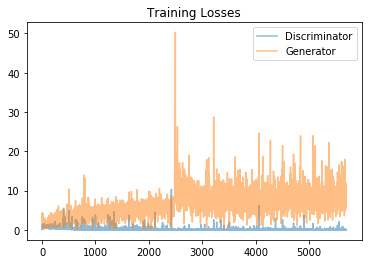

In [41]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [42]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [43]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

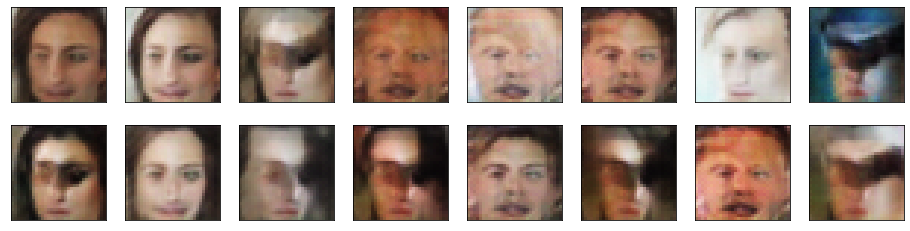

In [45]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 


The generated images have eyes , lips and other facial parts which is good but although it doesn't look good enough.
To improve this model we can try below things :
1. Increase Z_size to improve Generator loss
2. can use high resolution images so can use deeper network too.
3. can add more unbiased images like less white faces and increase number of brown and black celeb faces
4. can try changing the hyper parameters of adam optimizer

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.